<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone - Resumes and Job Ads Recommender

# Problem Statement

HR practitioners and/or hiring managers could have been spending too much time trying to sieve through many resumes for shortlisting suitable candidates whom they can contact for interview.
As a job seeker, we may also find ourselves spending so much times looking through plentiful job advertisements which may not be relevant to us.
Wouldn't it be nice if pre-selection can be done which will effectively save time for all of us?

We will be using Natural Language Processing and Recommender System to group similar job seekers / job advertisements.
Success will be evaluated by the (TBD on model) to match the job the grouped job seekers to the most suitable job advertisements and vice versa.

# Executive Summary

We scrape the website spiderjob.com for resumes. In view that api key is not available, we used BeautifulSoup and regex to get the desired information. As we encounter roadblock on the time connection timeout despite introducing bot agent, we limit the job categories to Accounting and Information Technology for this capstone. 
For the job ads, we based it on existing dataset that is available on Kaggle which was used for predicting fake job posting since the features in this dataset has 80% simiarity to the resumes dataset.

As we were cleaning the resumes dataset, we at the same made decision which features will be important for us to have and which are the one to drop. In view that job title, objective, experience and skills are free texts that hold meaningful words for our analysis, we create a new feature and combine all where we then split the text into words, return them to their root form and also remove the stop words. These are performed for the job ads dataset.

TBC.....


### Contents:
- [Data Cleaning & EDA - Resumes](#Data-Cleaning-&-EDA---Resumes)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict

%matplotlib inline

C:\Users\eukar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Cleaning & EDA - Resumes

There are 3 datasets altogether (Accounting resumes, IT resumes and job postings).\
We will first combined both Accounting and IT datasets for cleaning, followed by job postings.\
We will have to standardize the headers, selection of data between these datasets.

In [2]:
# import both resumes dataset (Accounting and IT)
accounting = pd.read_csv('.\datasets\Accounting.csv')
it = pd.read_csv('.\datasets\IT.csv')

In [3]:
# Check out the shape of both datasets and see if there are differences with the columns
print('Accounting set shape: ',accounting.shape)
print('IT set shape: ',it.shape)
print('Columns that are different between 2 datasets: ',accounting.columns.difference(it.columns))

Accounting set shape:  (491, 21)
IT set shape:  (795, 21)
Columns that are different between 2 datasets:  Index([], dtype='object')


In [4]:
# Combining both datasets using .append() method.
# Using .info() to double check that the combined dataset are append properly. 
resumes = accounting.append(it, sort=False)
resumes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286 entries, 0 to 794
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sn            1286 non-null   int64 
 1   date_posted   1286 non-null   object
 2   job_title     1286 non-null   object
 3   industry      1286 non-null   object
 4   state         1286 non-null   object
 5   state_name    1286 non-null   object
 6   resume_href   1286 non-null   object
 7   id            1286 non-null   int64 
 8   emp_type      1286 non-null   object
 9   availability  922 non-null    object
 10  desired_wage  891 non-null    object
 11  work_auth     1192 non-null   object
 12  job_level     1286 non-null   object
 13  will_travel   853 non-null    object
 14  edu_level     1286 non-null   object
 15  will_reloc    1189 non-null   object
 16  objective     1145 non-null   object
 17  exp           1237 non-null   object
 18  edu           1152 non-null   object
 19  skills 

In [5]:
# Check out top 5 rows of the dataset
resumes.head()

,sn,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,...,work_auth,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info
0,1,2/22/2020,auditor,Accounting,TX,Texas,/job/view-resume-82470.html,82470,Contractor,02/22/2020,...,Yes,"Management (Manager, Director)","Yes, More Than 75%",Masters,Yes,Strategist provides clients with more than a d...,"CPA Firm Consultant, Auditgoals.com 2019 - 202...","Master of Business Administration, FinanceBach...",NaN,NaN
1,2,2/11/2020,senior accountant,Accounting,OH,Ohio,/job/view-resume-82450.html,82450,Full-Time Permanent,2/1/2020,...,Yes,"Management (Manager, Director)",No,High School/Equivalent,No,NaN,Accomplished finance and accounting profession...,Three years at University Wisconsin Superior,BudgetsAdvanced ExcelFinancial StatementsStaff...,Software:Microsoft Dynamics GPPrism HRUltiproD...
2,3,1/31/2020,senior/mid-level financial services manager,Accounting,TX,Texas,/job/view-resume-82423.html,82423,Full-Time Permanent,NaN,...,Yes,"Management (Manager, Director)","Yes, Less Than 25%",Bachelors,Yes,Growth-focused and astute executive and influe...,"WELLS FARGO ▪ DALLAS, TX (1994–2019)Senior Vic...",EDUCATIONApplied Business Administration Manag...,Banking Administration | Risk Mitigation |Staf...,NaN
3,4,1/16/2020,brokerage operations,Accounting,NY,New York,/job/view-resume-82397.html,82397,Full-Time Permanent,Immediate,...,Yes,"Management (Manager, Director)",No,Certificate,No,"Analytical, performance-focused, and forward-t...","SOCIÉTÉ GÉNÉRALE – JERSEY CITY, NJVice Preside...",SCS Business and Technical Institute -New York...,Trade Posting and Payment EscalationInvestment...,"EARLIER CAREERMAN FINANCIAL, INC. – NEW YORK, ..."
4,5,12/16/2019,full charge bookkeeper,Accounting,CO,Colorado,/job/view-resume-82338.html,82338,Full-Time Permanent,NaN,...,Yes,Experienced with over 2 years experience,No,Bachelors,No,"Dynamic, goal-oriented, and analytical profess...","Echo River Expeditions, Cañon City, COReservat...",Coursework in Accounting and ComputerBessemer ...,"Microsoft Office Applications (Excel, Word, Po...",NaN


In [6]:
# Set index to sn and reset
resumes = resumes.set_index('sn').reset_index(drop=True)

# Change data type for date_posted
resumes['date_posted'] = pd.to_datetime(resumes['date_posted'])

### Data Dictionary

In [7]:
%%html
<style>
table {float:left}
</style>

| Data Dictionary for resume 	|                                                                                           	|
|:----------------------------	|:-------------------------------------------------------------------------------------------	|
| date_posted                	| the date resume was posted                                                                	|
| job_title                  	| job title that the candidate is looking for                                               	|
| industry                   	| job industry i.e. Accounting and Information Technology                                                                              	|
| state                      	| postal abbreviation of the state name                                                     	|
| state_name                 	| name of the US state                                                                      	|
| resume_href                	| link to join with url for entering resume                                                 	|
| id                         	| candidate respective resume id                                                            	|
| emp_type                   	| employment type e.g. full time/part time permanent, contract, etc                         	|
| availability               	| date that the candidate is available                                                      	|
| desired_wage               	| desired wage of the candidate                                                             	|
| work_auth                  	| if the candidate is authorized to work in USA                                             	|
| job_level                  	| job level of the candidate e.g. Executive (President, VP, CEO), mid-senior (Managers, Directors), etc                 |
| will_travel                	| if candidate is willing to travel if job is required                                      	|
| edu_level                  	| candidates' education level e.g. bachelors, masters, etc                                  	|
| will_reloc                 	| if candidate is willing to relocation if job is required                                  	|
| objective                  	| candidate's written objective, similar to an executive summary                            	|
| exp                        	| candidate's experience of past jobs                                                       	|
| edu                        	| candidate's education in details                                                          	|
| skills                     	| candidate's skills e.g. Microsoft office, financial reporting, etc                        	|
| add_info                   	| additional information of the candidates                                                  	|

### Let's look at each feature, perform data cleaning so that it can help us to decide which features will be useful for modeling.

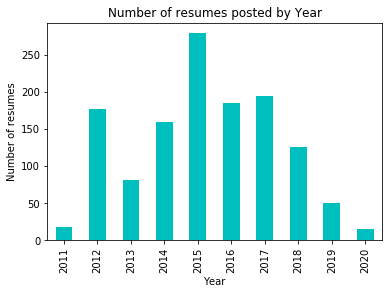

In [8]:
# Plot number of resumes by year
resumes.groupby(resumes['date_posted'].dt.year)['date_posted'].count().plot(kind='bar', color='c')
plt.title('Number of resumes posted by Year')
plt.xlabel('Year')
plt.ylabel('Number of resumes');

As we can see, the resumes we have are quite out-dated (mostly posted during the year 2014 to 2017). We will drop this feature since it will not make sense for use to select a resume posted many years ago for recent job posting as most likely the candidate would have found a job. For the purpose of this project, we will assume that the resumes are still valid and  candidates are still look for a job.\
Since we are summing that the resumes are still valid, we will not use the feature 'availability' as the dates may not be relevant as well.

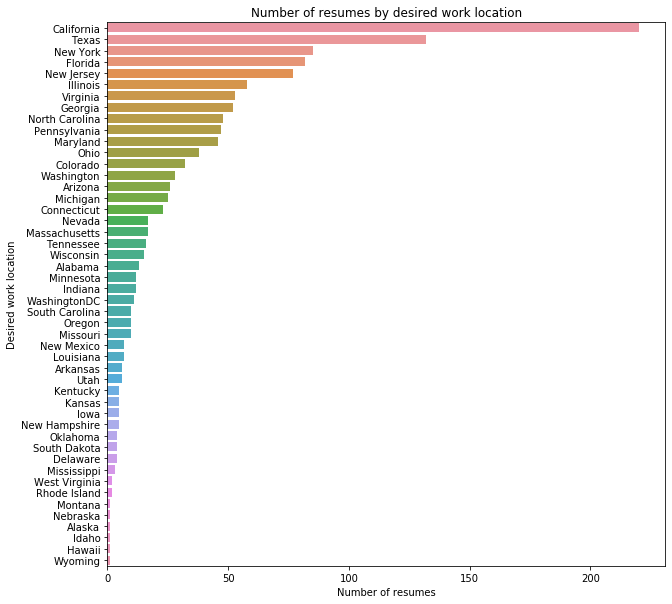

In [9]:
# Plotting the number of resumes by desired work location
plt.figure(figsize=(10,10))
loc = resumes.groupby(resumes['state_name'], as_index=False)['id'].count().sort_values(by='id',ascending=False)
sns.barplot(x=loc.id, y='state_name', data=loc, orient='h')
plt.title('Number of resumes by desired work location')
plt.xlabel('Number of resumes')
plt.ylabel('Desired work location');

In [10]:
# Check out the selection and frequencies of each selection of employment type
resumes.groupby('emp_type')['emp_type'].count()

emp_type
Contractor              151
Franchisee                1
Full-Time Permanent    1078
Full-Time Temporary      14
Internship                3
Other                    10
Part-Time Permanent      25
Part-Time Temporary       4
Name: emp_type, dtype: int64

In [11]:
# As we need to align the employment type between resumes and job posting datasets
# We will streamline to Contract, Full-time, Part-time, Other and Internship

# First, we will change all content to lower case
resumes['emp_type'] = resumes['emp_type'].str.lower()

# Rename Contractor to contract
resumes['emp_type'] = resumes['emp_type'].replace('contractor', 'contract')

In [12]:
# Check out what is the resume under Franchisee
resumes[resumes.emp_type == 'franchisee']

# Looking in details at the objective, experience and skills.
print('employment type: ',resumes.iloc[1018][7])
resumes.iloc[1018][15]

# Seems like a legit candidate, we will rename it under Other instead as it wasn't stipulated anywhere if the candidate is looking for full-time or part-time.
resumes['emp_type'] = resumes['emp_type'].replace('franchisee', 'other')

employment type:  franchisee


In [13]:
# Rename Full-time Permanent and Full-time Temporary to full-time
resumes['emp_type'] = resumes['emp_type'].replace('full-time permanent', 'full-time')
resumes['emp_type'] = resumes['emp_type'].replace('full-time temporary', 'full-time')

# Rename Part-time Termanent and Part-time Temporary to part-time
resumes['emp_type'] = resumes['emp_type'].replace('part-time permanent', 'part-time')
resumes['emp_type'] = resumes['emp_type'].replace('part-time temporary', 'part-time')

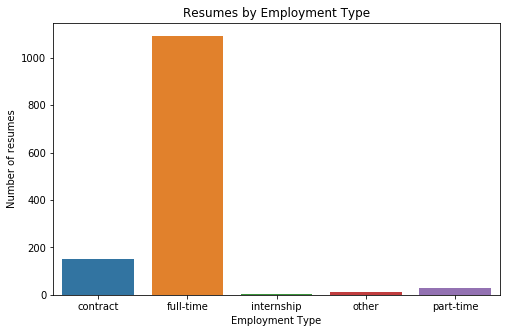

In [14]:
# Plot the revised emp_type to see the distribution
plt.figure(figsize=(8,5))
e_type = resumes.groupby(resumes['emp_type'], as_index=False)['id'].count().sort_values(by='emp_type')
sns.barplot(x='emp_type', y=e_type.id, data=e_type)
plt.title('Resumes by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Number of resumes');

Most of the job seekers are looking for full-time employment.

In [15]:
# Check out the desired wage
set(resumes.desired_wage)

{'$',
 '$100K-$120K',
 '$125. per hr',
 '$135,000',
 '$135,000 Base ($175,',
 '$15.00',
 '$15/hr',
 '$160,000- $170,000',
 '$160K + benefits',
 '$17.25 an hour',
 '$17.75 an hour',
 '$20/h',
 '$25,000',
 '$25/hr ',
 '$250,000',
 '$30,000',
 '$31,200',
 '$32,000.00',
 '$35,000',
 '$40,000',
 '$40K',
 '$42,000',
 '$45,000',
 '$50,000',
 '$60,000 - $70,000',
 '$60,000 -$70,000',
 '$60,000.00',
 '$60/hr C2C',
 '$600,000',
 '$65,000-$75,000',
 '$66,000.00',
 '$70,000',
 '$75,000',
 '$80 000',
 '$80,000',
 '$85,000',
 '$90,000',
 '0',
 '1/8/2019',
 '10,00,000 pa',
 '100',
 '100,000',
 '100,000.00',
 '10000',
 '100000',
 '100K',
 '104000',
 '105000',
 '108000',
 '11',
 '11.5',
 '110,000',
 '110000',
 '115,000',
 '115000',
 '115200',
 '118000',
 '12',
 '12,000',
 '120,000',
 '12000',
 '120000',
 '125000',
 '13.00hr',
 '130,000',
 '130000',
 '135,000',
 '135,000+',
 '135000',
 '1350000',
 '138000',
 '140000',
 '144,000',
 '145000',
 '148000',
 '15',
 '15,000.00',
 '15.00 Hr',
 '150,000',
 '1500

The `desired wage` is not consistent in term of unit. We can see that some are input as hourly rate, annual rate (with and without benefit/bonus) and many are without (negotiable, open, etc). In this regard, we will not select `desired_wage` as one of our features.

In [16]:
# Check out work_auth and there are missing value too
print('number of isnull: ', resumes['work_auth'].isnull().sum())
resumes.groupby('work_auth')['work_auth'].count()

number of isnull:  94


work_auth
No         12
Other       4
Yes      1176
Name: work_auth, dtype: int64

In [17]:
# As this is to indicate if the candidate is authorize to work in the US, we will assume NaN and Other as No.

# Rename Other to No
resumes['work_auth'] = resumes['work_auth'].replace('Other', 'No')

# Replace isnull with no
resumes['work_auth'] = resumes['work_auth'].replace(np.nan, 'No')

# Final check on the distribution
print('Percentage of Yes is {}% out of the total population.'.format(round(1176/1286*100)))
resumes.groupby('work_auth')['work_auth'].count()

Percentage of Yes is 91% out of the total population.


work_auth
No      110
Yes    1176
Name: work_auth, dtype: int64

In [56]:
# First, we will change all content to lower case
resumes['job_level'] = resumes['job_level'].str.lower()

# Check out job_level and we need to align the job level between resumes and job posting datasets
resumes.groupby('job_level')['job_level'].count()

job_level
associate      585
entry_level     96
executive       22
internship       3
mid_senior     580
Name: job_level, dtype: int64

In [19]:
# Rename executive (president, vp, ceo) to executive
resumes['job_level'] = resumes['job_level'].replace('executive (president, vp, ceo)', 'executive')

# Rename experienced with over 2 years experience to associate
resumes['job_level'] = resumes['job_level'].replace('experienced with over 2 years experience', 'associate')

# Rename management (manager, director) to mid-senior
resumes['job_level'] = resumes['job_level'].replace('management (manager, director)', 'mid_senior')

# Rename new grad/entry level to entry_level
resumes['job_level'] = resumes['job_level'].replace('new grad/entry level', 'entry_level')

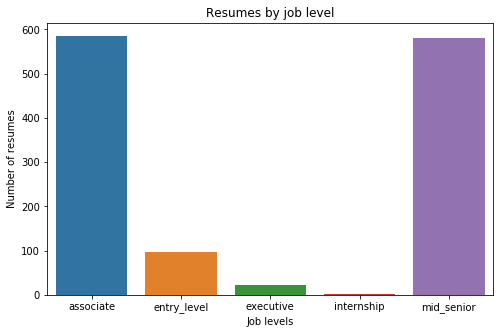

In [20]:
# Plot the revised job level to see the distribution
plt.figure(figsize=(8,5))
j_level = resumes.groupby(resumes['job_level'], as_index=False)['id'].count().sort_values(by='job_level')
sns.barplot(x='job_level', y=j_level.id, data=j_level)
plt.title('Resumes by job level')
plt.xlabel('Job levels')
plt.ylabel('Number of resumes');

The majority of the candidates we have are looking for job in the associate and mid_senior level which are not surprising as we are only covering 2 specialization i.e. Accounting and Information Technology.\
Thus we can expect a higher percentage of PMET* `Professional, Managers, Executives and Technicians`

In [21]:
# Check out will_travel and there are missing value too
print('number of isnull: ', resumes['will_travel'].isnull().sum())
resumes.groupby('will_travel')['will_travel'].count()

number of isnull:  433


will_travel
No                    167
Yes, 25-50%           249
Yes, 50-75%            72
Yes, Less Than 25%    291
Yes, More Than 75%     74
Name: will_travel, dtype: int64

In [22]:
# Since No is an option, we will input isnull to No
resumes['will_travel'] = resumes['will_travel'].replace(np.nan, 'No')

# Also, this is asking on the willing to travel, for those with a Yes, we will just indicate a Yes regardless of %
resumes['will_travel'] = resumes['will_travel'].replace('Yes, 25-50%', 'Yes')
resumes['will_travel'] = resumes['will_travel'].replace('Yes, 50-75%', 'Yes')
resumes['will_travel'] = resumes['will_travel'].replace('Yes, Less Than 25%', 'Yes')
resumes['will_travel'] = resumes['will_travel'].replace('Yes, More Than 75%', 'Yes')

# Final check on the distribution
resumes.groupby('will_travel')['will_travel'].count()

will_travel
No     600
Yes    686
Name: will_travel, dtype: int64

In [23]:
# Check out edu_level
resumes.groupby('edu_level')['edu_level'].count()

edu_level
Bachelors                 631
Certificate                76
College                    52
Degree                     63
High School/Equivalent    100
JD                          1
MBA                        29
Masters                   263
Unspecified                71
Name: edu_level, dtype: int64

In [24]:
# As we need to align with the education level in job posting, we will:

# Rename High School/Equivalent to High School
resumes['edu_level'] = resumes['edu_level'].replace('High School/Equivalent', 'High_school')

# Classify MBA under Masters
resumes['edu_level'] = resumes['edu_level'].replace('MBA', 'Masters')

In [25]:
# Check out what is JD
resumes[resumes['edu_level']=='JD']

# Looking in details at the objective, experience and skills.
print('education level: ',resumes.iloc[1233][13])
resumes.iloc[1233][17]

education level:  JD


'Certified WAN Professional Program     LANWAN ProfessionalJuris Doctorate Degree     University of Southern CaliforniaBachelors of Science Major Economics &     Finance\t\t  California State University, Fullerton'

In [26]:
# As indicated that it has Bachelor of Science, we will rename JD to Bachelors
resumes['edu_level'] = resumes['edu_level'].replace('JD', 'Bachelors')

# Last but not least, change all content to lower case
resumes['edu_level'] = resumes['edu_level'].str.lower()

# Check the final output
resumes.groupby('edu_level')['edu_level'].count()

1286

Percentage of bachelors and masters combined is 72% out of the total population.


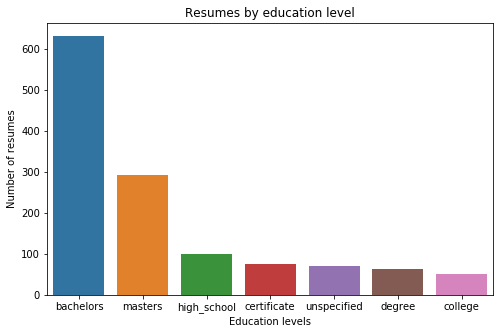

In [27]:
# Plot the revised education level to see the distribution
plt.figure(figsize=(8,5))
e_level = resumes.groupby(resumes['edu_level'], as_index=False)['id'].count().sort_values(by='id', ascending=False)
sns.barplot(x='edu_level', y=e_level.id, data=e_level)
plt.title('Resumes by education level')
plt.xlabel('Education levels')
plt.ylabel('Number of resumes');

print('Percentage of bachelors and masters combined is {}% out of the total population.'.format(round((632+292)/1286*100)))

In [28]:
resumes.head()

,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,desired_wage,work_auth,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info
0,2020-02-22,auditor,Accounting,TX,Texas,/job/view-resume-82470.html,82470,contract,02/22/2020,NaN,Yes,mid_senior,Yes,masters,Yes,Strategist provides clients with more than a d...,"CPA Firm Consultant, Auditgoals.com 2019 - 202...","Master of Business Administration, FinanceBach...",NaN,NaN
1,2020-02-11,senior accountant,Accounting,OH,Ohio,/job/view-resume-82450.html,82450,full-time,2/1/2020,"75,000.00",Yes,mid_senior,No,high_school,No,NaN,Accomplished finance and accounting profession...,Three years at University Wisconsin Superior,BudgetsAdvanced ExcelFinancial StatementsStaff...,Software:Microsoft Dynamics GPPrism HRUltiproD...
2,2020-01-31,senior/mid-level financial services manager,Accounting,TX,Texas,/job/view-resume-82423.html,82423,full-time,NaN,NaN,Yes,mid_senior,Yes,bachelors,Yes,Growth-focused and astute executive and influe...,"WELLS FARGO ▪ DALLAS, TX (1994–2019)Senior Vic...",EDUCATIONApplied Business Administration Manag...,Banking Administration | Risk Mitigation |Staf...,NaN
3,2020-01-16,brokerage operations,Accounting,NY,New York,/job/view-resume-82397.html,82397,full-time,Immediate,90000,Yes,mid_senior,No,certificate,No,"Analytical, performance-focused, and forward-t...","SOCIÉTÉ GÉNÉRALE – JERSEY CITY, NJVice Preside...",SCS Business and Technical Institute -New York...,Trade Posting and Payment EscalationInvestment...,"EARLIER CAREERMAN FINANCIAL, INC. – NEW YORK, ..."
4,2019-12-16,full charge bookkeeper,Accounting,CO,Colorado,/job/view-resume-82338.html,82338,full-time,NaN,35000,Yes,associate,No,bachelors,No,"Dynamic, goal-oriented, and analytical profess...","Echo River Expeditions, Cañon City, COReservat...",Coursework in Accounting and ComputerBessemer ...,"Microsoft Office Applications (Excel, Word, Po...",NaN


In [29]:
# Check out will_travel and there are missing value too
print('number of isnull: ', resumes['will_reloc'].isnull().sum())
resumes.groupby('will_reloc')['will_reloc'].count()

number of isnull:  97


will_reloc
No               532
No Preference     12
Undecided         75
Yes              570
Name: will_reloc, dtype: int64

In [30]:
# Since No is an option, we will input isnull to No
resumes['will_reloc'] = resumes['will_reloc'].replace(np.nan, 'No')

# Also, this is asking on the willing to relocate, for those No preference and undecided, we will assume that there is
# still a small possibility on their willingness to relocate.
resumes['will_reloc'] = resumes['will_reloc'].replace('No Preference', 'Yes')
resumes['will_reloc'] = resumes['will_reloc'].replace('Undecided', 'Yes')

# Final check on the distribution
resumes.groupby('will_reloc')['will_reloc'].count()

will_reloc
No     629
Yes    657
Name: will_reloc, dtype: int64

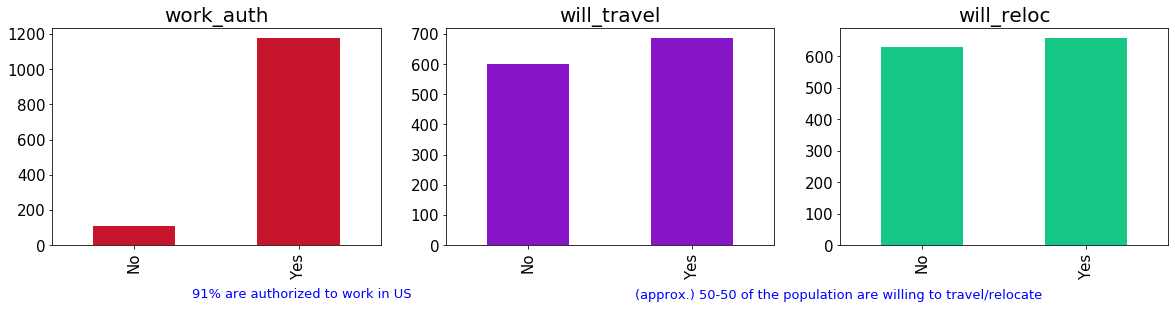

In [31]:
# There are 3 features that we have reduced to Yes/No
# work_auth, will_travel, will_reloc
# plot a graph to see the distribution of the resumes
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4))

resumes.work_auth.value_counts().sort_index().plot.bar(ax=ax1, fontsize=15, color='#C7152C')
ax1.set_title('work_auth', fontsize=20)
ax1.text(0.35,-300, '91% are authorized to work in US', fontsize=13, color='b')

resumes.will_travel.value_counts().sort_index().plot.bar(ax=ax2, fontsize=15, color='#8515C7')
ax2.set_title('will_travel', fontsize=20)

resumes.will_reloc.value_counts().sort_index().plot.bar(ax=ax3, fontsize=15, color='#15C785')
ax3.set_title('will_reloc', fontsize=20)
ax3.text(-1.75,-170, '(approx.) 50-50 of the population are willing to travel/relocate', fontsize=13, color='b');

As `job_title`, `objective`, `experience`, `skills` are free text that articulate the type of roles that the candidates might be looking out for. We will combined these 4 features into 1 and apply vectorize it with stopwords to see what are the keys words that could stand out to help us to determine the key skills / roles.

In [57]:
# Create a new column to merge the 4 features into 1.
resumes['combine_text'] = resumes['job_title'] + ' ' + resumes['objective'].fillna('') + ' ' + resumes['exp'].fillna('') + ' ' +resumes['skills'].fillna('')

# Split the dataframe by industry so that we can visualize the words in combine_text
# Creating acct_cleaned dataframe
mask = resumes.mask(resumes.industry == 'Information Technology')
acct_cleaned = mask[mask['industry'].notnull()]
print('Shape of Accounting function dataframe: ',acct_cleaned.shape)

# Creating it_cleaned dataframe
mask1 = resumes.mask(resumes.industry == 'Accounting')
it_cleaned = mask1[mask1['industry'].notnull()]
print('Shape of Information Technology function dataframe: ',it_cleaned.shape)

Shape of Accounting function dataframe:  (491, 21)
Shape of Information Technology function dataframe:  (795, 21)


In [33]:
# Check out the top 3 of Accounting to ensure we split the data correctly
acct_cleaned.head(3)

,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,desired_wage,...,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info,combine_text
0,2020-02-22,auditor,Accounting,TX,Texas,/job/view-resume-82470.html,82470.0,contract,02/22/2020,NaN,...,mid_senior,Yes,masters,Yes,Strategist provides clients with more than a d...,"CPA Firm Consultant, Auditgoals.com 2019 - 202...","Master of Business Administration, FinanceBach...",NaN,NaN,auditor Strategist provides clients with more ...
1,2020-02-11,senior accountant,Accounting,OH,Ohio,/job/view-resume-82450.html,82450.0,full-time,2/1/2020,"75,000.00",...,mid_senior,No,high_school,No,NaN,Accomplished finance and accounting profession...,Three years at University Wisconsin Superior,BudgetsAdvanced ExcelFinancial StatementsStaff...,Software:Microsoft Dynamics GPPrism HRUltiproD...,senior accountant Accomplished finance and ac...
2,2020-01-31,senior/mid-level financial services manager,Accounting,TX,Texas,/job/view-resume-82423.html,82423.0,full-time,NaN,NaN,...,mid_senior,Yes,bachelors,Yes,Growth-focused and astute executive and influe...,"WELLS FARGO ▪ DALLAS, TX (1994–2019)Senior Vic...",EDUCATIONApplied Business Administration Manag...,Banking Administration | Risk Mitigation |Staf...,NaN,senior/mid-level financial services manager Gr...


In [34]:
# Check out the top 3 of Information Technology to ensure we split the data correctly
it_cleaned.reset_index(inplace=True)
it_cleaned.head(3)

,index,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,...,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info,combine_text
0,491,2020-03-26,it helpdesk support technician,Information Technology,NV,Nevada,/job/view-resume-82527.html,82527.0,full-time,3/26/2020,...,associate,Yes,bachelors,Yes,Dedicated IT expert with 10+ years’ experience...,"THE COSMOPOLITAN, LAS VEGAS, NV\t\t\t\t\t\t\t ...","UNIVERSITY OF ALABAMA, BIRMINGHAM\t\t\t\t\t\t ...","Skype, Creston, Ivanti App Sense, Altiris, SSC...",NaN,it helpdesk support technician Dedicated IT ex...
1,492,2020-03-23,it helpdesk support technician,Information Technology,NV,Nevada,/job/view-resume-82521.html,82521.0,full-time,NaN,...,mid_senior,Yes,bachelors,Yes,Dedicated IT expert with 10+ years’ experience...,"THE COSMOPOLITAN, LAS VEGAS, NV\t\t\t\t\t\t\t ...",CODE ACADEMY | Python\t\t\t\t\t\t\t\t\t ...,"Skype, Creston, Ivanti App Sense, Altiris, SSC...",NaN,it helpdesk support technician Dedicated IT ex...
2,493,2020-03-02,it education professional,Information Technology,FL,Florida,/job/view-resume-82483.html,82483.0,full-time,NaN,...,mid_senior,No,bachelors,No,"Accomplished, performance-focused, and multifa...",Professional ExperienceBK & TJ Enterprises LLC...,EducationBachelor of Arts in Business Administ...,Technical SkillsOperating Systems:IBM MVS | Ho...,CertificationCompTIA Network+CompTIA Linux+MTA...,"it education professional Accomplished, perfor..."


In [35]:
# Create a function to run through the bag of words to return the basic form
def text_to_words(series):
    new_list = []
    lemmatizer = WordNetLemmatizer()
    
    
    for i in range(len(series)):
        chars = re.sub("[^a-zA-Z0-9+]", " ", series[i]) # remove non-letters
        words = chars.lower().split() # convert to lower case, split into individual words
        stops = set(stopwords.words('english')) # convert stop words to a set
        meaningful_words = [w for w in words if not w in stops] # remove stop words
        meaningful_words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
        
        string_clean = " ".join(meaningful_words_lem)
        new_list.append(string_clean)
    return new_list

In [36]:
# Applying function to orginal combined dataset.
# Renaming the lemmatized text to the original Series
resumes['combine_text'] = text_to_words(resumes['combine_text'])
resumes.head()

,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,desired_wage,...,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info,combine_text
0,2020-02-22,auditor,Accounting,TX,Texas,/job/view-resume-82470.html,82470,contract,02/22/2020,NaN,...,mid_senior,Yes,masters,Yes,Strategist provides clients with more than a d...,"CPA Firm Consultant, Auditgoals.com 2019 - 202...","Master of Business Administration, FinanceBach...",NaN,NaN,auditor strategist provides client decade hand...
1,2020-02-11,senior accountant,Accounting,OH,Ohio,/job/view-resume-82450.html,82450,full-time,2/1/2020,"75,000.00",...,mid_senior,No,high_school,No,NaN,Accomplished finance and accounting profession...,Three years at University Wisconsin Superior,BudgetsAdvanced ExcelFinancial StatementsStaff...,Software:Microsoft Dynamics GPPrism HRUltiproD...,senior accountant accomplished finance account...
2,2020-01-31,senior/mid-level financial services manager,Accounting,TX,Texas,/job/view-resume-82423.html,82423,full-time,NaN,NaN,...,mid_senior,Yes,bachelors,Yes,Growth-focused and astute executive and influe...,"WELLS FARGO ▪ DALLAS, TX (1994–2019)Senior Vic...",EDUCATIONApplied Business Administration Manag...,Banking Administration | Risk Mitigation |Staf...,NaN,senior mid level financial service manager gro...
3,2020-01-16,brokerage operations,Accounting,NY,New York,/job/view-resume-82397.html,82397,full-time,Immediate,90000,...,mid_senior,No,certificate,No,"Analytical, performance-focused, and forward-t...","SOCIÉTÉ GÉNÉRALE – JERSEY CITY, NJVice Preside...",SCS Business and Technical Institute -New York...,Trade Posting and Payment EscalationInvestment...,"EARLIER CAREERMAN FINANCIAL, INC. – NEW YORK, ...",brokerage operation analytical performance foc...
4,2019-12-16,full charge bookkeeper,Accounting,CO,Colorado,/job/view-resume-82338.html,82338,full-time,NaN,35000,...,associate,No,bachelors,No,"Dynamic, goal-oriented, and analytical profess...","Echo River Expeditions, Cañon City, COReservat...",Coursework in Accounting and ComputerBessemer ...,"Microsoft Office Applications (Excel, Word, Po...",NaN,full charge bookkeeper dynamic goal oriented a...


In [37]:
# Next, we will do the same but for acct_clean dataframe for the purpose of visualization via WordCloud.
# Renaming the lemmatized text to the original Series
acct_cleaned['combine_text'] = text_to_words(acct_cleaned['combine_text'])
acct_cleaned.head()

C:\Users\eukar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,desired_wage,...,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info,combine_text
0,2020-02-22,auditor,Accounting,TX,Texas,/job/view-resume-82470.html,82470.0,contract,02/22/2020,NaN,...,mid_senior,Yes,masters,Yes,Strategist provides clients with more than a d...,"CPA Firm Consultant, Auditgoals.com 2019 - 202...","Master of Business Administration, FinanceBach...",NaN,NaN,auditor strategist provides client decade hand...
1,2020-02-11,senior accountant,Accounting,OH,Ohio,/job/view-resume-82450.html,82450.0,full-time,2/1/2020,"75,000.00",...,mid_senior,No,high_school,No,NaN,Accomplished finance and accounting profession...,Three years at University Wisconsin Superior,BudgetsAdvanced ExcelFinancial StatementsStaff...,Software:Microsoft Dynamics GPPrism HRUltiproD...,senior accountant accomplished finance account...
2,2020-01-31,senior/mid-level financial services manager,Accounting,TX,Texas,/job/view-resume-82423.html,82423.0,full-time,NaN,NaN,...,mid_senior,Yes,bachelors,Yes,Growth-focused and astute executive and influe...,"WELLS FARGO ▪ DALLAS, TX (1994–2019)Senior Vic...",EDUCATIONApplied Business Administration Manag...,Banking Administration | Risk Mitigation |Staf...,NaN,senior mid level financial service manager gro...
3,2020-01-16,brokerage operations,Accounting,NY,New York,/job/view-resume-82397.html,82397.0,full-time,Immediate,90000,...,mid_senior,No,certificate,No,"Analytical, performance-focused, and forward-t...","SOCIÉTÉ GÉNÉRALE – JERSEY CITY, NJVice Preside...",SCS Business and Technical Institute -New York...,Trade Posting and Payment EscalationInvestment...,"EARLIER CAREERMAN FINANCIAL, INC. – NEW YORK, ...",brokerage operation analytical performance foc...
4,2019-12-16,full charge bookkeeper,Accounting,CO,Colorado,/job/view-resume-82338.html,82338.0,full-time,NaN,35000,...,associate,No,bachelors,No,"Dynamic, goal-oriented, and analytical profess...","Echo River Expeditions, Cañon City, COReservat...",Coursework in Accounting and ComputerBessemer ...,"Microsoft Office Applications (Excel, Word, Po...",NaN,full charge bookkeeper dynamic goal oriented a...


In [38]:
# Then, we will do the same but for it_clean dataframe for the purpose of visualization via WordCloud.
# Renaming the lemmatized text to the original Series
it_cleaned['combine_text'] = text_to_words(it_cleaned['combine_text'])
it_cleaned.head()

C:\Users\eukar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,date_posted,job_title,industry,state,state_name,resume_href,id,emp_type,availability,...,job_level,will_travel,edu_level,will_reloc,objective,exp,edu,skills,add_info,combine_text
0,491,2020-03-26,it helpdesk support technician,Information Technology,NV,Nevada,/job/view-resume-82527.html,82527.0,full-time,3/26/2020,...,associate,Yes,bachelors,Yes,Dedicated IT expert with 10+ years’ experience...,"THE COSMOPOLITAN, LAS VEGAS, NV\t\t\t\t\t\t\t ...","UNIVERSITY OF ALABAMA, BIRMINGHAM\t\t\t\t\t\t ...","Skype, Creston, Ivanti App Sense, Altiris, SSC...",NaN,helpdesk support technician dedicated expert 1...
1,492,2020-03-23,it helpdesk support technician,Information Technology,NV,Nevada,/job/view-resume-82521.html,82521.0,full-time,NaN,...,mid_senior,Yes,bachelors,Yes,Dedicated IT expert with 10+ years’ experience...,"THE COSMOPOLITAN, LAS VEGAS, NV\t\t\t\t\t\t\t ...",CODE ACADEMY | Python\t\t\t\t\t\t\t\t\t ...,"Skype, Creston, Ivanti App Sense, Altiris, SSC...",NaN,helpdesk support technician dedicated expert 1...
2,493,2020-03-02,it education professional,Information Technology,FL,Florida,/job/view-resume-82483.html,82483.0,full-time,NaN,...,mid_senior,No,bachelors,No,"Accomplished, performance-focused, and multifa...",Professional ExperienceBK & TJ Enterprises LLC...,EducationBachelor of Arts in Business Administ...,Technical SkillsOperating Systems:IBM MVS | Ho...,CertificationCompTIA Network+CompTIA Linux+MTA...,education professional accomplished performanc...
3,494,2020-02-25,senior systems administrator supervisor,Information Technology,CA,California,/job/view-resume-82473.html,82473.0,full-time,Immediately,...,mid_senior,No,high_school,No,"Innovative, results-driven, and analytical pro...",RELEVANT EXPERIENCEMARKET SCAN INFORMATION SYS...,"EDUCATIONCivil Engineering, Community College ...",NaN,PROFESSIONAL DEVELOPMENTCertification\tCisco C...,senior system administrator supervisor innovat...
4,495,2020-02-23,"it manager, network administrator",Information Technology,OH,Ohio,/job/view-resume-82471.html,82471.0,full-time,Immediately,...,mid_senior,Yes,college,No,"To obtain a position as an IT professional, ap...",Director of Technical Services\t2007 to Presen...,"A.A.S, Computer Network Administration and Sec...",•\tOperating Systems: Microsoft Windows 7 / 8 ...,Certifications•\tCompTIA A+ Core Hardware•\tCo...,manager network administrator obtain position ...


In [39]:
# Create a function for generating WordCloud
stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        max_words=300,
        max_font_size=80, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

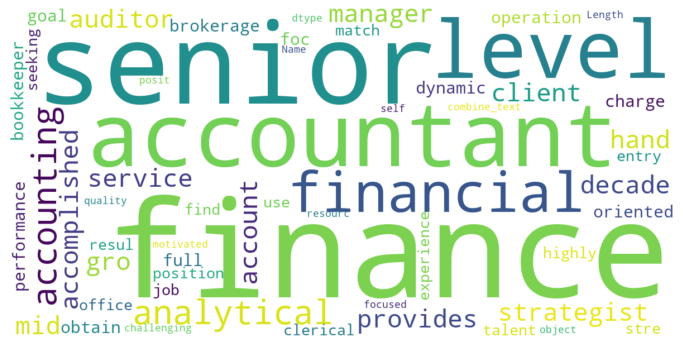

In [40]:
# Generate WordCloud for acct_cleaned dataset.
show_wordcloud(acct_cleaned['combine_text'])

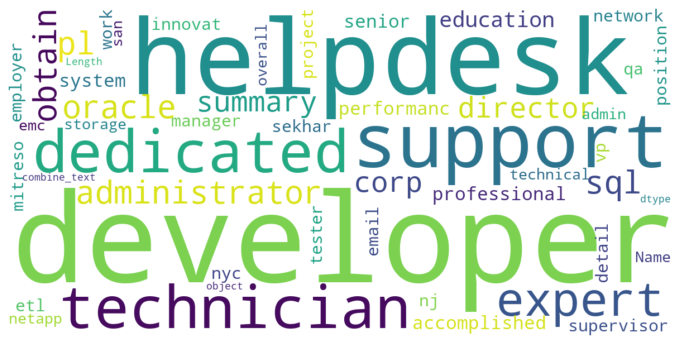

In [41]:
# Generate WordCloud for it_cleaned dataset.
show_wordcloud(it_cleaned['combine_text'])

Based on the wordcloud, we are able to tell that keywords such as senior, level, accounting, finance, auditor appear more prominate than others for the Accounting industry. As for Information Technology, we are seeing helpdesk, support, technican, expert, oracle, sql are appearing more.\
However, we need to know in detail the keywords that are appearing either more by frequencies or by weight so that it will help us to determine the which features we want to engineer later during the pre-processing.

Using `CountVectorizer` to look at the words that appear the most based on the number of times appearing in the document.

In [42]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer(stop_words = 'english')

# Fit and transform datasets
acct_cvec = vectorizer.fit_transform(acct_cleaned['combine_text'])

# Convert the total word count into DataFrame
acct_cvec_df = pd.DataFrame(acct_cvec.todense(), columns=vectorizer.get_feature_names())

# Check out the head of the Dataframe
acct_cvec_df.head()

,00,000,000and,000hours,002,009,01,0145,0168,019hours,...,zelenkofske,zero,ziegler,ziler,zip,zoll,zoo,zoological,zulily,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# find out how many times each word appear in combine_text by creating a 'Total' row at the end of the dataframe:
acct_cvec_df.loc['Total',:]= acct_cvec_df.sum(axis=0)
acct_cvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
acct_cvec_df_count = pd.DataFrame(acct_cvec_df.loc['Total',:].sort_values(ascending=False))
acct_cvec_df_count.head()

,Total
account,1593.0
accounting,1593.0
financial,1406.0
management,999.0
tax,910.0


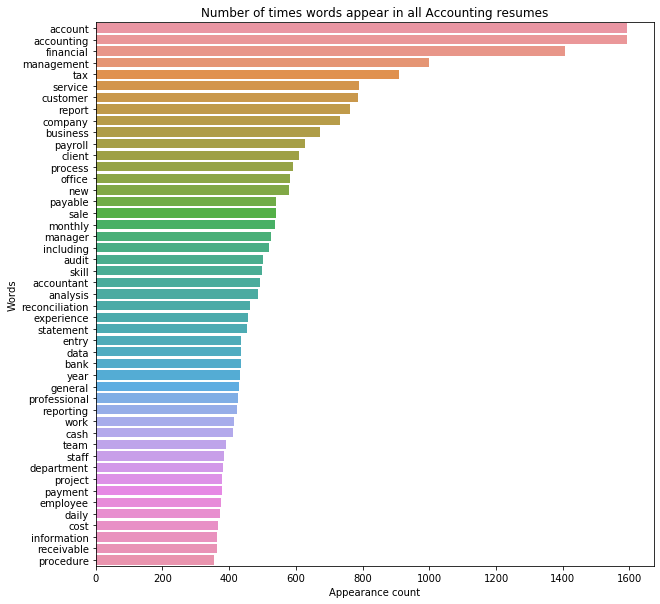

In [44]:
# Reset index
acct_cvec_df_count.reset_index(inplace=True)

# Sort counts
acct_cvec_df_count = acct_cvec_df_count[acct_cvec_df_count.Total > 350]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=acct_cvec_df_count.Total, y='index', data=acct_cvec_df_count, orient='h')
plt.title('Number of times words appear in all Accounting resumes')
plt.xlabel('Appearance count')
plt.ylabel('Words');

In [45]:
# Let's make the above the same for Information Technology dataset
# Fit and transform dataset
it_cvec = vectorizer.fit_transform(it_cleaned['combine_text'])

# Convert the total word count into DataFrame
it_cvec_df = pd.DataFrame(it_cvec.todense(), columns=vectorizer.get_feature_names())

# Check out the head of the Dataframe
it_cvec_df.head()

,00,000,000broadcasters,000lockheed,000s,0010309819,007,0095,01,0129,...,zoning,zookeeper,zoom,zoomsolely,zope,zos,zuchwil,zuri,zurich,zxing
0,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# find out how many times each word appear in combine_text by creating a 'Total' row at the end of the dataframe:
it_cvec_df.loc['Total',:]= it_cvec_df.sum(axis=0)
it_cvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
it_cvec_df_count = pd.DataFrame(it_cvec_df.loc['Total',:].sort_values(ascending=False))
it_cvec_df_count.head()

,Total
project,3608.0
management,3524.0
business,2897.0
data,2807.0
service,2803.0


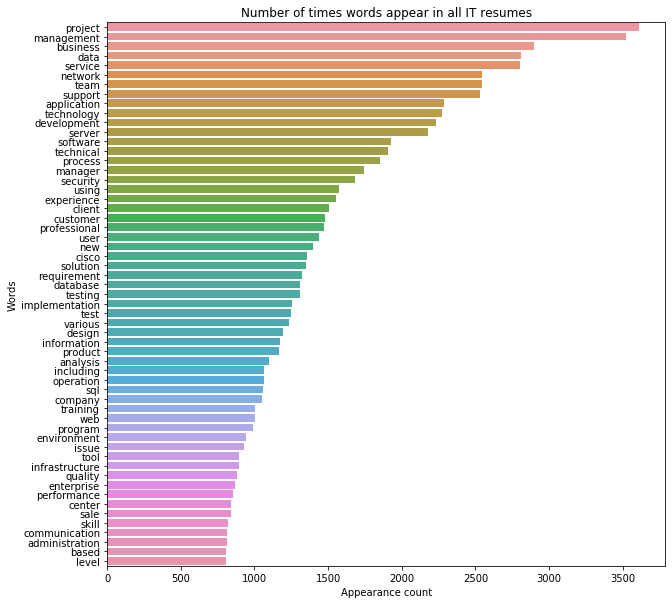

In [47]:
# Reset index
it_cvec_df_count.reset_index(inplace=True)

# Sort counts
it_cvec_df_count = it_cvec_df_count[it_cvec_df_count.Total > 800]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=it_cvec_df_count.Total, y='index', data=it_cvec_df_count, orient='h')
plt.title('Number of times words appear in all IT resumes')
plt.xlabel('Appearance count')
plt.ylabel('Words');

Using `TfidfVectorizer` to look at the words based on the weight of the words.

In [48]:
# Instantiate CountVectorizer
tfvec = TfidfVectorizer(stop_words = 'english')

# Fit and transform datasets
acct_tfvec = tfvec.fit_transform(acct_cleaned['combine_text'])

# Convert the total word count into DataFrame
acct_tfvec_df = pd.DataFrame(acct_tfvec.todense(), columns=tfvec.get_feature_names())

# Check out the head of the Dataframe
acct_tfvec_df.head()

,00,000,000and,000hours,002,009,01,0145,0168,019hours,...,zelenkofske,zero,ziegler,ziler,zip,zoll,zoo,zoological,zulily,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# find out what is the weight of each word in combine_text by creating a 'Total' row at the end of the dataframe:
acct_tfvec_df.loc['Total',:]= acct_tfvec_df.sum(axis=0)
acct_tfvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
acct_tfvec_df_count = pd.DataFrame(acct_tfvec_df.loc['Total',:].sort_values(ascending=False))
acct_tfvec_df_count.head()

,Total
accounting,29.426280
account,29.156710
financial,24.600507
tax,19.389713
customer,17.791850


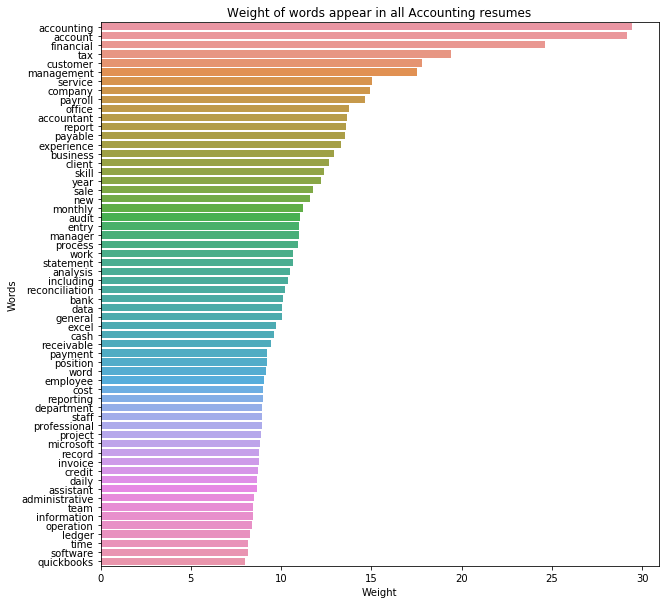

In [50]:
# Reset index
acct_tfvec_df_count.reset_index(inplace=True)

# Sort counts
acct_tfvec_df_count = acct_tfvec_df_count[acct_tfvec_df_count.Total > 8]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=acct_tfvec_df_count.Total, y='index', data=acct_tfvec_df_count, orient='h')
plt.title('Weight of words appear in all Accounting resumes')
plt.xlabel('Weight')
plt.ylabel('Words');

In [51]:
# Let's make the above the same for Information Technology dataset
# Fit and transform datasets
it_tfvec = tfvec.fit_transform(it_cleaned['combine_text'])

# Convert the total word count into DataFrame
it_tfvec_df = pd.DataFrame(it_tfvec.todense(), columns=tfvec.get_feature_names())

# Check out the head of the Dataframe
it_tfvec_df.head()

,00,000,000broadcasters,000lockheed,000s,0010309819,007,0095,01,0129,...,zoning,zookeeper,zoom,zoomsolely,zope,zos,zuchwil,zuri,zurich,zxing
0,0.0,0.089547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.089547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# find out what is the weight of each word in combine_text by creating a 'Total' row at the end of the dataframe:
it_tfvec_df.loc['Total',:]= it_tfvec_df.sum(axis=0)
it_tfvec_df.loc['Total',:].sort_values(ascending=False)

# Convert it to a DataFrame
it_tfvec_df_count = pd.DataFrame(it_tfvec_df.loc['Total',:].sort_values(ascending=False))
it_tfvec_df_count.head()

,Total
network,40.012202
project,39.776424
management,35.770103
business,32.272411
service,29.627481


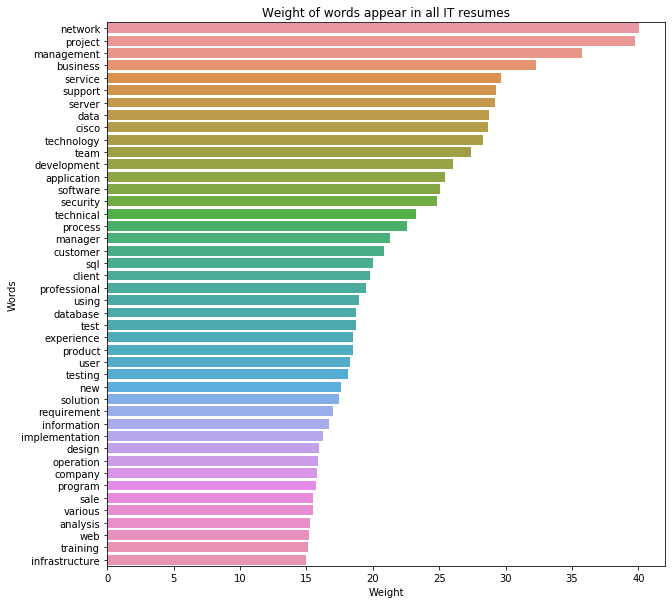

In [53]:
# Reset index
it_tfvec_df_count.reset_index(inplace=True)

# Sort counts
it_tfvec_df_count = it_tfvec_df_count[it_tfvec_df_count.Total > 15]

# Plotting the above Dataframe to a bar chart
plt.figure(figsize=(10,10))
sns.barplot(x=it_tfvec_df_count.Total, y='index', data=it_tfvec_df_count, orient='h')
plt.title('Weight of words appear in all IT resumes')
plt.xlabel('Weight')
plt.ylabel('Words');

In [54]:
# Saving a copy of the cleaned dataset for pre-processing and modeling
resumes.to_csv('./datasets/resumes.csv', index=False)